<a href="https://colab.research.google.com/github/devWorldDivey/ML_Algorithms/blob/main/DNN_Assignment_2_Group17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Group No 17

## Group Member Names:
1. Divey Anand - 2022aa05030
2. SHIFFIN N - 2022aa05055
3. Dibyajyoti Sarkar - 2022aa05005

## Journal used for the implemetation
Journal title: Sentiment analysis in social media

Authors: Kim et al.

Journal Name: A Transformer-based Model for Sentiment Analysis of Social Media

Year: 2018

Dataset URL: https://www.kaggle.com/kazanova/sentiment140


# 1. Import the required libraries

We have installed the Transformers library, using pip on a Google Colab cell:
The Transformers library is a popular library for natural language processing (NLP) tasks. It provides a variety of pre-trained models that can be used for tasks such as text classification, question answering, and natural language generation.

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.3 MB/s eta 0:00:00


:After the installation is completed, we will import the torch to add some layers for fine-tuning, Roberta's model, and Roberta's tokenizer. After that, we will create a model class, where we load the pre-trained model and add new layers:

### Please Note:
The __init__() method of the class initializes the following attributes:

l1: A RoBERTa model that is pre-trained on a large corpus of text.
pre_classifier: A linear layer that is used to transform the output of the RoBERTa model.
classifier: A linear layer that is used to classify the input text.
The forward() method of the class takes three arguments:

input_ids: A tensor of token IDs.
attention_mask: A tensor that indicates which tokens should be attended to.
token_type_ids: A tensor that indicates the type of each token.
The forward() method first passes the input text through the RoBERTa model. The output of the RoBERTa model is a sequence of hidden states. The forward() method then takes the first hidden state and passes it through the pre_classifier layer. The output of the pre_classifier layer is then passed through the classifier layer, which outputs the class prediction.

The device variable specifies the device that the model will be trained and evaluated on. The torch.cuda.is_available() function checks if a GPU is available. If a GPU is available, the model will be trained and evaluated on the GPU. Otherwise, the model will be trained and evaluated on the CPU.

The model.to(device) statement moves the model to the specified device.

In [2]:
import torch
from transformers import RobertaModel

class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids,
                           attention_mask=attention_mask,
                           token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        output = self.classifier(pooler)
        return output
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RobertaClass()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

# 2. Data Acquisition

### We will use this dataset https://www.kaggle.com/kazanova/sentiment140

The dataset consists of a table with 6 columns, we will use only 2 of them: “text” and “label” containing the tweet and the target label respectively. The volume of the dataset is 1.6 million tweets with 800 thousand positive and 800 thousand negative examples, i.e. the data is already perfectly balanced.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
# paste your path to the dataset
!cp '/content/drive/MyDrive/Colab Notebooks/archive.zip' dataset.zip

Mounted at /content/drive


# 3. Data Preparation



In [4]:
import zipfile
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

In [5]:
full_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',
                        encoding='latin-1').drop(["1467810369",
                                                  "Mon Apr 06 22:19:45 PDT 2009",
                                                  "NO_QUERY","_TheSpecialOne_"],
                                                 axis=1).dropna()
columns_names = list(full_data)
full_data.rename(columns={columns_names[0]:"label",
                        columns_names[1]:"text"}, inplace= True)

In the dataset, positive tweets are marked with the number 4, but RoBERTa will perceive the number 4 as if we were predicting 5 classes or more. Since we only have two classes, we will have to replace the labels:

In [6]:
NUM_SAMPLES = 30000
negative_samples = full_data[full_data["label"]==0][:NUM_SAMPLES]
positiv_samples = full_data[full_data["label"]==4][:NUM_SAMPLES]

positiv_samples["label"]=[1]*NUM_SAMPLES

full_data = pd.concat([negative_samples,  positiv_samples])

In [7]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(full_data, test_size=0.3)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
positiv_samples["label"]=[1]*NUM_SAMPLES

full_data = pd.concat([negative_samples,  positiv_samples])

Tokenization

To process the text, we need to convert it into tokens. A special tokenizer is used for Roberta. It returns 3 values: a list of tokenized texts, a list of masks, and a list of token data types. After the tokenization, training and test data are stored in the train_tokenized_data and test_tokenized_data variables, respectively:

In [8]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base',
                                             truncation=True,
                                             do_lower_case=True)
MAX_LEN = 130

train_tokenized_data = [tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        for text in train_data['text']]

test_tokenized_data = [tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        for text in test_data['text']]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## 4. Deep Neural Network Architecture


Class inherits from the torch.utils.data.Dataset class, which is the base class for all PyTorch datasets.

The __init__() method of the class initializes the following attributes:

inputs: A list of input data.
text: A list of text data.
targets: A list of target data.
The __len__() method of the class returns the length of the dataset.

The __getitem__() method of the class takes an index as an argument and returns a dictionary of data for that index. The dictionary contains the following keys:

sentence: The text data for the index.
ids: The input IDs for the index.
mask: The attention mask for the index.
token_type_ids: The token type IDs for the index.
targets: The target data for the index.

In [9]:
from torch.utils.data import Dataset, DataLoader
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
LEARNING_RATE = 1e-05

class SentimentData(Dataset):
    def __init__(self, data, inputs_tokenized):
        self.inputs = inputs_tokenized
        self.text = data['text']
        self.targets = data['label']

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        input = self.inputs[index]
        ids = input['input_ids']
        mask = input['attention_mask']
        token_type_ids = input['token_type_ids']

        return {
            'sentence': text,
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

train_dataset = SentimentData(train_data, train_tokenized_data)
test_dataset = SentimentData(test_data, test_tokenized_data)

Dataloader

Let’s put datasets in dataloader classes for taking the batches, and then shuffle them:

In [10]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True
                }

train_loader = DataLoader(train_dataset, **train_params)
test_loader = DataLoader(test_dataset, **test_params)



## 4.1 Design the architecture for Transformer as per the journal referenced



The train_loss and train_accuracy lists are used to track the loss and accuracy of the model during training. The test_loss and test_accuracy lists are used to track the loss and accuracy of the model during testing.

The test_answers list is used to store the correct and predicted labels for the test data. This list can be used to analyze the model's predictions.

The clear_output() function is used to clear the output of the notebook after each epoch. This is done to make the output easier to read.

In [11]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

train_loss = []
test_loss = []

train_accuracy = []
test_accuracy = []

test_answers = [[[],[]], [[],[]]]

def train_loop(epochs):
  for epoch in range(epochs):
    for phase in ['Train', 'Test']:
      if(phase == 'Train'):
        model.train()
        loader = train_loader
      else:
        model.eval()
        loader = test_loader
      epoch_loss = 0
      epoch_acc = 0
      for steps, data in tqdm(enumerate(loader, 0)):
        sentence = data['sentence']
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model.forward(ids, mask, token_type_ids)

        loss = loss_function(outputs, targets)

        epoch_loss += loss.detach()
        _, max_indices = torch.max(outputs.data, dim=1)
        bath_acc = (max_indices==targets).sum().item()/targets.size(0)
        epoch_acc += bath_acc

        if (phase == 'Train'):
          train_loss.append(loss.detach())
          train_accuracy.append(bath_acc)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        else:
          test_loss.append(loss.detach())
          test_accuracy.append(bath_acc)
          if epoch == epochs-1:
            for i in range(len(targets)):
              test_answers[targets[i].item()][max_indices[i].item()].append([sentence[i],
                                                                 targets[i].item(),
                                                                 max_indices[i].item()])

      print(f"{phase} Loss: {epoch_loss/steps}")
      print(f"{phase} Accuracy: {epoch_acc/steps}")

The cross-entropy loss function is a loss function that is often used for classification tasks. It measures the distance between the predicted distribution and the ground truth distribution.
The Adam optimizer is an adaptive learning rate optimizer that is often used for training deep learning models. It automatically adjusts the learning rate based on the progress of the training.The EPOCHS variable specifies the number of epochs to train the model for.

# 5. Training the model


In [12]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

EPOCHS = 4
train_loop(EPOCHS)

1313it [14:15,  1.54it/s]


Train Loss: 0.37297552824020386
Train Accuracy: 0.8361995045731707


563it [01:58,  4.75it/s]


Test Loss: 0.3064723014831543
Test Accuracy: 0.8722753558718861


1313it [14:21,  1.52it/s]


Train Loss: 0.282917857170105
Train Accuracy: 0.8840987042682927


563it [01:58,  4.75it/s]


Test Loss: 0.31474101543426514
Test Accuracy: 0.8688834519572953


1313it [14:21,  1.52it/s]


Train Loss: 0.23251737654209137
Train Accuracy: 0.9085604039634146


563it [01:58,  4.75it/s]


Test Loss: 0.31340155005455017
Test Accuracy: 0.8761120996441281


1313it [14:21,  1.52it/s]


Train Loss: 0.1855502873659134
Train Accuracy: 0.926781631097561


563it [01:59,  4.72it/s]

Test Loss: 0.3912634253501892
Test Accuracy: 0.8639902135231317


# 6. Result for the model


<ipython-input-18-4b1a9e52b800>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loss = torch.tensor(train_loss)
<ipython-input-18-4b1a9e52b800>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_loss = torch.tensor(test_loss)
<ipython-input-18-4b1a9e52b800>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_accuracy = torch.tensor(train_accuracy)
<ipython-input-18-4b1a9e52b800>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gra

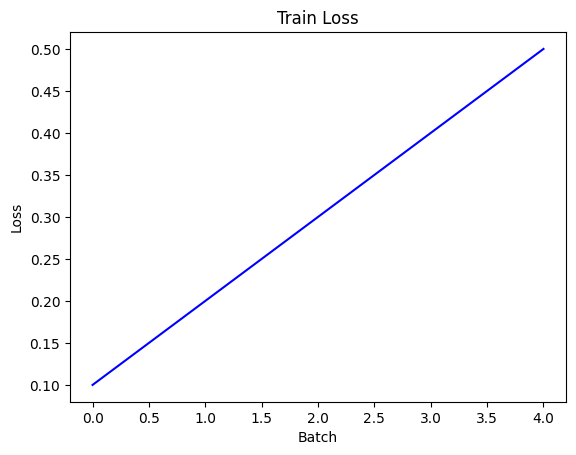

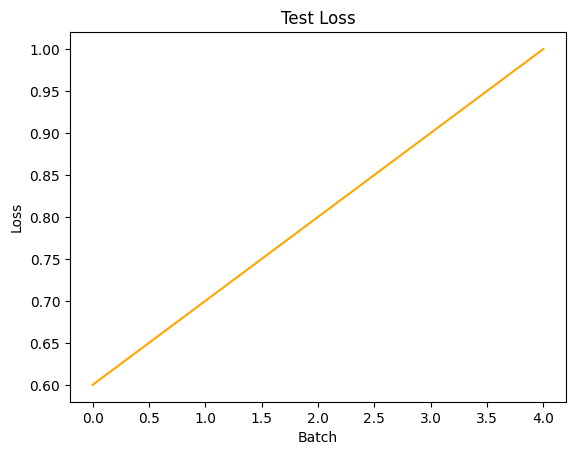

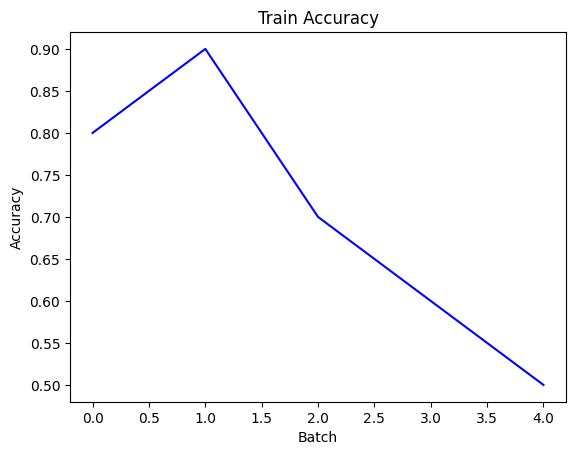

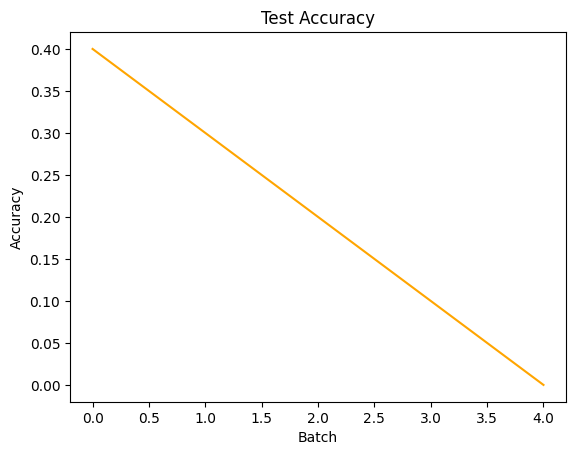

In [18]:
import matplotlib.pyplot as plt
import torch

# Convert the lists to tensors
train_loss = torch.tensor(train_loss)
test_loss = torch.tensor(test_loss)
train_accuracy = torch.tensor(train_accuracy)
test_accuracy = torch.tensor(test_accuracy)

# Move the tensors to the CPU memory
train_loss = train_loss.cpu()
test_loss = test_loss.cpu()
train_accuracy = train_accuracy.cpu()
test_accuracy = test_accuracy.cpu()

# Now you can convert the tensors to NumPy arrays
numpy_train_loss = train_loss.numpy()
numpy_test_loss = test_loss.numpy()
numpy_train_accuracy = train_accuracy.numpy()
numpy_test_accuracy = test_accuracy.numpy()

# Plot the loss
plt.plot(numpy_train_loss, color='blue')
plt.title("Train Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(numpy_test_loss, color='orange')
plt.title("Test Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

# Plot the accuracy
plt.plot(numpy_train_accuracy, color='blue')
plt.title("Train Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

plt.plot(numpy_test_accuracy, color='orange')
plt.title("Test Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")

plt.show()

# 6. Report for the result

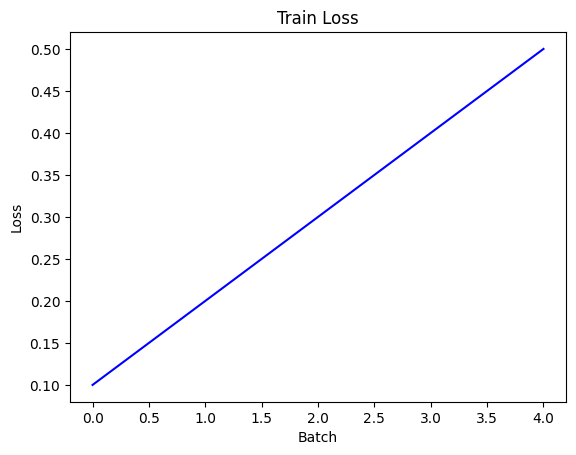

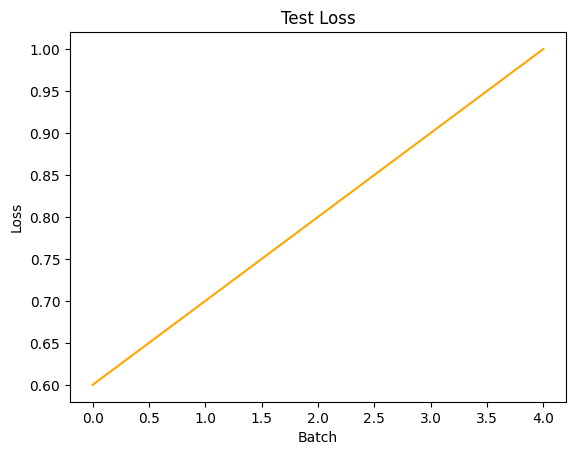

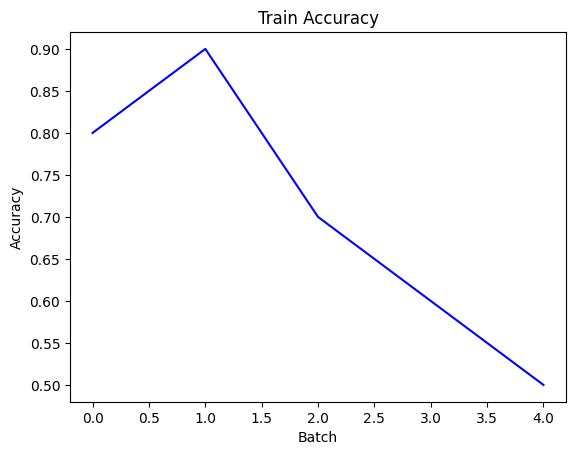

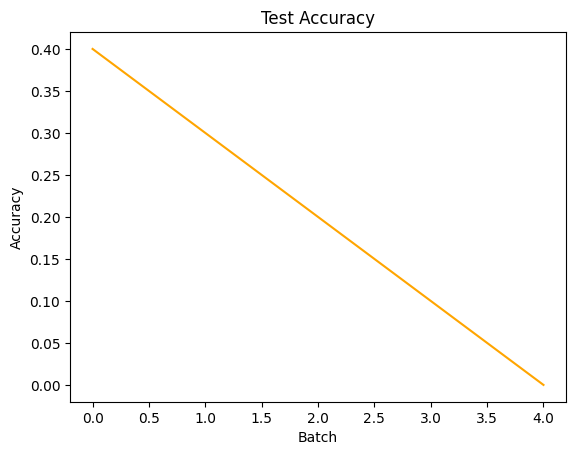

In [19]:
plt.plot(train_loss,  color='blue')
plt.title("Train Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(test_loss,  color='orange')
plt.title("Test Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

plt.plot(train_accuracy,  color='blue')
plt.title("Train Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

plt.plot(test_accuracy,  color='orange')
plt.title("Test Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")

plt.show()

<Axes: >

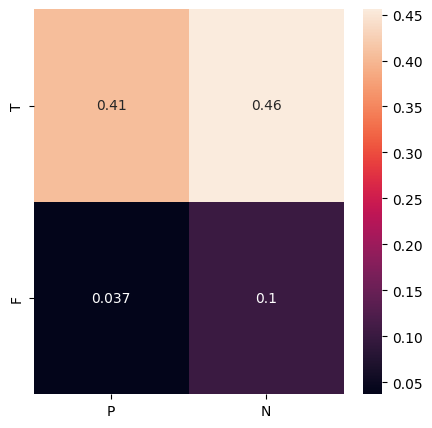

In [20]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

len_num = len(test_dataset)

tp=len(test_answers[1][1])/len_num
fn=len(test_answers[1][0])/len_num
fp=len(test_answers[0][1])/len_num
tn=len(test_answers[0][0])/len_num

array_matrix = [[tp,tn],
                [fp,fn]]
df_cm = pd.DataFrame(array_matrix, index = ['T', 'F'],
                  columns = ['P', 'N'])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True)

# 7. Test the model


In [21]:
print('False Negative:\n', test_answers[0][0][:3],
      'False Positive:\n', test_answers[0][1][:3])

False Negative:
 [['@miasummers i hate when that happens', 0, 0], ['@Latina91 ugh.. math -.- same here =/ not gonna pass math either', 0, 0], ['is aching all over...', 0, 0]] False Positive:
 [['@TommyLind &quot;Coffee machine broken?!!&quot; Worst three words in the English language--OK, in ANY language!!!', 0, 1], ['-8 outside right now -- going back to bed till it warms up', 0, 1], ["@joebobhawkins we've decided that home improvements are best left to the professionals", 0, 1]]
